In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# Technical Analysis
from talib import RSI, BBANDS, ATR, NATR, MACD

# scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

from scipy.stats import spearmanr

# neural network
from tqdm import tqdm
import torch
import torch.nn as nn
  # our model
from LSTM import LSTM

import pyfolio as pf
from pathlib import Path
import pandas as pd
from alphalens.tears import create_summary_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns

import warnings
warnings.filterwarnings('ignore')

/Users/pupipatsingkhorn/miniconda3/envs/datascience/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Data Preprocessing

In [2]:
# def read_tickers_sp500(file_path):
#     with open(file_path, 'r') as file:
#         tickers_sp500 = [line.strip() for line in file]
#     return tickers_sp500

# tickers_sp500 = read_tickers_sp500('tickers_sp500.txt')
# print(tickers_sp500)

In [3]:
# Download data

# Stocks list
# top 7 MarketCap in S&P500(^GSPC)
# tickers = ['^GSPC', 'AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META']
tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'TSLA', 'META', 'AMD', 'INTC', 'NFLX', 'PYPL', 'ASML']
# tickers = tickers_sp500
start_date = None
end_date = None

df_prices_download = yf.download(tickers=tickers, start=start_date, end=end_date, group_by='ticker')

[*********************100%%**********************]  12 of 12 completed


In [4]:
# Format into large table
# col: OHLCV
# rows(multi-index): Ticker, Date

df_prices = df_prices_download.stack(level=0, dropna=False)
df_prices = df_prices.swaplevel(0, 1)
df_prices = df_prices.loc[tickers].sort_index(level='Ticker')
df_prices.dropna(inplace=True)

# Use 'Adj Close' instead of 'Close'
df_prices.drop('Close', axis=1, inplace=True)
df_prices.rename(columns={'Adj Close': 'Close'}, inplace=True)

df_prices

Price                    Open        High         Low       Close       Volume
Ticker Date                                                                   
AAPL   1980-12-12    0.128348    0.128906    0.128348    0.099058  469033600.0
       1980-12-15    0.122210    0.122210    0.121652    0.093890  175884800.0
       1980-12-16    0.113281    0.113281    0.112723    0.086998  105728000.0
       1980-12-17    0.115513    0.116071    0.115513    0.089152   86441600.0
       1980-12-18    0.118862    0.119420    0.118862    0.091737   73449600.0
...                       ...         ...         ...         ...          ...
TSLA   2024-05-06  183.800003  187.559998  182.199997  184.759995   84390300.0
       2024-05-07  182.399994  183.259995  177.399994  177.809998   75045900.0
       2024-05-08  171.589996  176.059998  170.149994  174.720001   79969500.0
       2024-05-09  175.009995  175.619995  171.369995  171.970001   65950300.0
       2024-05-10  173.050003  173.059998  167.750000  168.470001   72350200.0

[82556 rows x 5 columns]

### Remove stocks with less than 10 years of data

In [5]:
min_obs_days = 10 * 252 # NYSE and NASDAQ average 252 trading days a year
num_obs = df_prices.groupby(level='Ticker').size()

tickers_to_drop = num_obs[num_obs < min_obs_days].index
print(f'Amount tickers_to_drop: {tickers_to_drop.size}')
print(f'tickers_to_drop: {tickers_to_drop}')

df_prices = df_prices.drop(tickers_to_drop, level='Ticker')

Amount tickers_to_drop: 1
tickers_to_drop: Index(['PYPL'], dtype='object', name='Ticker')


# Feature Engineering

### RSI - Relative Strength Index
RSI compares the magnitude of recent price changes across stocks to identify stocks as overbought or oversold.

In [6]:
rsi = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(RSI)
df_prices['RSI'] = rsi

### Bollinger Bands
Bollinger Bands is a technical analysis tool used to determine where prices are high and low relative to each other.

In [7]:
def compute_bb(close):
    high, mid, low = BBANDS(np.log1p(close), timeperiod=20)
    return pd.DataFrame({'BB_High': high,
                         'BB_Mid': mid, # SMA20
                         'BB_Low': low},
                        index=close.index)

bbands = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_bb)
df_prices = pd.concat([df_prices, bbands], axis=1)

### ATR - Average True Range
The average true range (ATR) indicator shows the volatility of the market.

In [8]:
by_ticker = df_prices.groupby('Ticker', group_keys=False)

def compute_atr(stock_data):
    atr = ATR(stock_data.High,
              stock_data.Low,
              stock_data.Close,
              timeperiod=14)
    return atr.sub(atr.mean()).div(atr.std())

df_prices['ATR'] = by_ticker.apply(compute_atr)
# Normalized Average True Range (NATR)
df_prices['NATR'] = by_ticker.apply(lambda x: NATR(high=x.High, low=x.Low, close=x.Close))

### MACD - Moving Average Convergence/Divergence

In [9]:
def compute_macd(close):
    macd = MACD(close)[0]
    return macd.sub(macd.mean()).div(macd.std())

df_prices['MACD'] = df_prices.groupby(level='Ticker', group_keys=False).Close.apply(compute_macd)

## Determine Investment Universe

### Dollar Volume

In [10]:
# Close: USD
# Volumn: Amount
df_prices['Dollar_Volume'] = (df_prices.loc[:, 'Close']
                           .mul(df_prices.loc[:, 'Volume'], axis=0))

df_prices['Dollar_Volume'] /= 1e6 # Dollar_Volume: Million USD

### Resample Monthly Freq.
- drop OHL_V
- use Dollar_Volumn instead of Volume

In [11]:
remian_cols = [c for c in df_prices.columns.unique(0) if c not in ['Dollar_Volume', 'Volume', 'Open', 'High', 'Low']]

# New data frame: 'data' - load to model
data = (
    pd.concat(
        [
        # avg(1M) Dollar_Volume
            df_prices.unstack("Ticker")
            .Dollar_Volume.resample('D')
            .mean()
            .stack("Ticker")
            .to_frame("Dollar_Volume"),
        # (Adj)Close & Technical Indicators
            df_prices.unstack("Ticker")[remian_cols]
            .resample('D')
            .last()
            .stack("Ticker")
        ],
        axis=1
    )
    .swaplevel()
    .sort_index(level='Ticker')
    .dropna()
)

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 79964 entries, ('AAPL', Timestamp('1981-01-30 00:00:00')) to ('TSLA', Timestamp('2024-05-10 00:00:00'))
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Dollar_Volume  79964 non-null  float64
 1   Close          79964 non-null  float64
 2   RSI            79964 non-null  float64
 3   BB_High        79964 non-null  float64
 4   BB_Mid         79964 non-null  float64
 5   BB_Low         79964 non-null  float64
 6   ATR            79964 non-null  float64
 7   NATR           79964 non-null  float64
 8   MACD           79964 non-null  float64
dtypes: float64(9)
memory usage: 6.3+ MB


### Select 10 most-traded equities
Select the 10 most-traded stocks based on a 5-year rolling average of dollar volume.

In [12]:
data['Dollar_Volume'] = (data.loc[:, 'Dollar_Volume']
                         .unstack('Ticker')
                         .rolling(window=5*12, min_periods=12)
                         .mean()
                         .stack()
                         .swaplevel())

data['Dollar_Volume_Rank'] = (data
                           .groupby('Date')
                           .Dollar_Volume
                           .rank(ascending=False))

data = data[data.Dollar_Volume_Rank < 10]
data = data.drop(['Dollar_Volume', 'Dollar_Volume_Rank'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73426 entries, ('AAPL', Timestamp('1981-02-17 00:00:00')) to ('TSLA', Timestamp('2024-05-10 00:00:00'))
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Close    73426 non-null  float64
 1   RSI      73426 non-null  float64
 2   BB_High  73426 non-null  float64
 3   BB_Mid   73426 non-null  float64
 4   BB_Low   73426 non-null  float64
 5   ATR      73426 non-null  float64
 6   NATR     73426 non-null  float64
 7   MACD     73426 non-null  float64
dtypes: float64(8)
memory usage: 5.3+ MB


In [13]:
len(data.index.unique('Ticker'))

11

## Lagged Return

In [14]:
data = data.rename_axis(index={'Date': 'date', 'Ticker': 'ticker'})

In [15]:
lags = [1, 5, 10, 21, 42, 63]
returns = data.groupby(level='ticker').Close.pct_change()

q = 0.0001

for lag in lags:
    data[f'return_{lag}d'] = (data.groupby(level='ticker').Close
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(q),
                                                       upper=x.quantile(1 - q)))
                                .add(1)
                                .pow(1 / lag)
                                .sub(1)
                                )

# for t in [1, 2, 3, 4, 5]:
#     for lag in [1, 5, 10, 21]:
#         data[f'return_{lag}d_lag{t}'] = (data.groupby(level='ticker')
#                                            [f'return_{lag}d'].shift(t * lag))

for t in [1, 5, 10, 21]:
    data[f'target_{t}d'] = data.groupby(level='ticker')[f'return_{t}d'].shift(-t)

In [16]:
data

Close        RSI   BB_High    BB_Mid    BB_Low  \
ticker date                                                              
AAPL   1981-02-17    0.090013  37.411058  0.111134  0.095559  0.079984   
       1981-02-18    0.093890  43.705698  0.110077  0.094836  0.079594   
       1981-02-19    0.088290  37.793472  0.108693  0.093759  0.078825   
       1981-02-20    0.083553  33.646515  0.107088  0.092406  0.077724   
       1981-02-23    0.084845  35.718125  0.104954  0.091132  0.077311   
...                       ...        ...       ...       ...       ...   
TSLA   2024-05-06  184.759995  58.568064  5.298160  5.124982  4.951805   
       2024-05-07  177.809998  53.504669  5.298773  5.125243  4.951713   
       2024-05-08  174.720001  51.377923  5.300302  5.126093  4.951884   
       2024-05-09  171.970001  49.492442  5.298940  5.125338  4.951736   
       2024-05-10  168.470001  47.122208  5.297919  5.124583  4.951246   

                        ATR       NATR      MACD  return_1d  return_5d  \
ticker date                                                              
AAPL   1981-02-17 -0.734659  32.744820 -0.126765        NaN        NaN   
       1981-02-18 -0.734500  31.642349 -0.126454   0.043068        NaN   
       1981-02-19 -0.734919  32.949788 -0.126649  -0.059637        NaN   
       1981-02-20 -0.735333  34.085746 -0.127162  -0.053655        NaN   
       1981-02-23 -0.735408  33.436898 -0.127389   0.015463        NaN   
...                     ...        ...       ...        ...        ...   
TSLA   2024-05-06  1.073717   5.059411  0.453168   0.019703  -0.009764   
       2024-05-07  1.047063   5.177315  0.455812  -0.037616  -0.006042   
       2024-05-08  1.026336   5.205684  0.407455  -0.017378  -0.005926   
       2024-05-09  0.961365   5.087674  0.324589  -0.015739  -0.009097   
       2024-05-10  0.915248   5.047552  0.204824  -0.020352  -0.014452   

                   return_10d  return_21d  return_42d  return_63d  target_1d  \
ticker date                                                                    
AAPL   1981-02-17         NaN         NaN         NaN         NaN   0.043068   
       1981-02-18         NaN         NaN         NaN         NaN  -0.059637   
       1981-02-19         NaN         NaN         NaN         NaN  -0.053655   
       1981-02-20         NaN         NaN         NaN         NaN   0.015463   
       1981-02-23         NaN         NaN         NaN         NaN  -0.035531   
...                       ...         ...         ...         ...        ...   
TSLA   2024-05-06    0.026636    0.005430    0.001084    0.000321  -0.037616   
       2024-05-07    0.020833    0.001312   -0.000112   -0.000638  -0.017378   
       2024-05-08    0.007507   -0.000585   -0.000084   -0.001127  -0.015739   
       2024-05-09    0.001047    0.000058   -0.000789   -0.001545  -0.020352   
       2024-05-10    0.000107   -0.001700   -0.001248   -0.002202        NaN   

                   target_5d  target_10d  target_21d  
ticker date                                           
AAPL   1981-02-17  -0.018880    0.000478   -0.000688  
       1981-02-18  -0.015131   -0.004685   -0.003156  
       1981-02-19   0.000000    0.000971    0.000232  
       1981-02-20   0.017905    0.005530    0.004683  
       1981-02-23   0.015741   -0.004137    0.003726  
...                      ...         ...         ...  
TSLA   2024-05-06        NaN         NaN         NaN  
       2024-05-07        NaN         NaN         NaN  
       2024-05-08        NaN         NaN         NaN  
       2024-05-09        NaN         NaN         NaN  
       2024-05-10        NaN         NaN         NaN  

[73426 rows x 18 columns]

## Date Indicators

In [17]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 73426 entries, ('AAPL', Timestamp('1981-02-17 00:00:00')) to ('TSLA', Timestamp('2024-05-10 00:00:00'))
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Close       73426 non-null  float64
 1   RSI         73426 non-null  float64
 2   BB_High     73426 non-null  float64
 3   BB_Mid      73426 non-null  float64
 4   BB_Low      73426 non-null  float64
 5   ATR         73426 non-null  float64
 6   NATR        73426 non-null  float64
 7   MACD        73426 non-null  float64
 8   return_1d   73415 non-null  float64
 9   return_5d   73371 non-null  float64
 10  return_10d  73316 non-null  float64
 11  return_21d  73195 non-null  float64
 12  return_42d  72964 non-null  float64
 13  return_63d  72733 non-null  float64
 14  target_1d   73415 non-null  float64
 15  target_5d   73371 non-null  float64
 16  target_10d  73316 non-null  float64
 17  target_21d  73195 non-null  f

In [20]:
from statsmodels.tsa.stattools import adfuller

def adf(x):
  res = adfuller(x)
  print("Test-Statistic:", res[0])
  print("P-Value:", res[1])
  if res[1] < 0.05:
    print("Stationary")
  else:
    print("Non-Stationary")

adf(data['return_1d'].dropna())

Test-Statistic: -33.543099153973245
P-Value: 0.0
Stationary


<Axes: xlabel='ticker,date'>

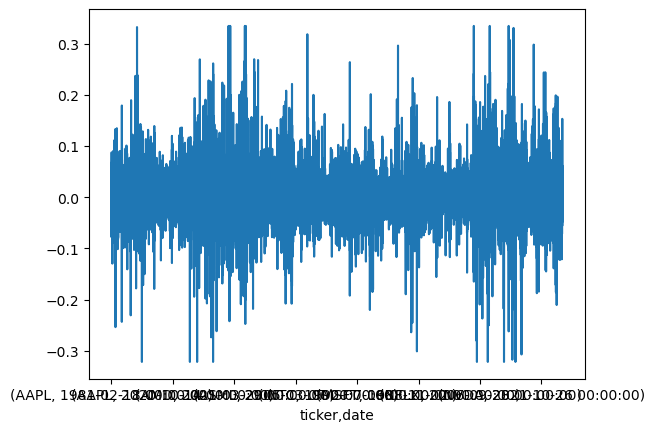

In [21]:
data['return_1d'].dropna().plot()

In [ ]:
assert

# Model

In [ ]:
data.dropna(inplace=True)

y = data.filter(like='target')
# y_binary = (y > 0).astype(int) # Classification Problem
X = data.drop(y.columns, axis=1)

In [ ]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [ ]:
YEAR = 252

train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR/test_period_length)
lookahead =1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [ ]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = pd.concat([train.reset_index(), test.reset_index()], axis=0)
    n = len(df)
    assert n == len(df.drop_duplicates())
    print(train.groupby(level='ticker').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='ticker').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

In [ ]:
# helper func.
def plot_preds_scatter(df, ticker=None):
    if ticker is not None:
        idx = pd.IndexSlice
        df = df.loc[idx[ticker, :], :]
    j = sns.jointplot(x='predicted', y='actuals',
                      robust=True, ci=None,
                      line_kws={'lw': 1, 'color': 'k'},
                      scatter_kws={'s': 1},
                      data=df,
                      kind='reg')
    j.ax_joint.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.1%}'.format(y)))
    j.ax_joint.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.1%}'.format(x)))
    j.ax_joint.set_xlabel('Predicted')
    j.ax_joint.set_ylabel('Actuals')

def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9,
            s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}',
            horizontalalignment='left',
            verticalalignment='center',
            transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

def plot_rolling_ic(df):
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(14, 8))
    rolling_result = df.sort_index().rolling(21).mean().dropna()
    mean_ic = df.ic.mean()
    rolling_result.ic.plot(ax=axes[0],
                           title=f'Information Coefficient (Mean: {mean_ic:.2f})',
                           lw=1)
    axes[0].axhline(0, lw=.5, ls='-', color='k')
    axes[0].axhline(mean_ic, lw=1, ls='--', color='k')

    mean_rmse = df.rmse.mean()
    rolling_result.rmse.plot(ax=axes[1],
                             title=f'Root Mean Squared Error (Mean: {mean_rmse:.2%})',
                             lw=1,
                             ylim=(0, df.rmse.max()))
    axes[1].axhline(df.rmse.mean(), lw=1, ls='--', color='k')
    sns.despine()
    plt.tight_layout()

In [ ]:
train_period_length = 63
test_period_length = 10
n_splits = int(3 * YEAR / test_period_length)
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [ ]:
%%time
target = f'target_{lookahead}d'
lr_predictions, lr_scores = [], []
lr = LinearRegression()
for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
    lr.fit(X=X_train, y=y_train)
    y_pred = lr.predict(X_test)

    preds = y_test.to_frame('actuals').assign(predicted=y_pred)
    preds_by_day = preds.groupby(level='date')
    scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,
                                                               x.actuals)[0] * 100)
                        .to_frame('ic'),
                        preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted,
                                                                                y_true=x.actuals)))
                        .to_frame('rmse')], axis=1)

    lr_scores.append(scores)
    lr_predictions.append(preds)

lr_scores = pd.concat(lr_scores)
lr_predictions = pd.concat(lr_predictions)

In [ ]:
lr_r, lr_p = spearmanr(lr_predictions.actuals, lr_predictions.predicted)
print(f'Information Coefficient (overall): {lr_r:.3%} (p-value: {lr_p:.4%})')

In [ ]:
lr_predictions

# signal

In [ ]:
idx = pd.IndexSlice

def get_trade_prices(tickers, start, stop):
    prices = data
    prices.index.names = ['ticker', 'date']
    prices = prices.loc[idx[tickers, str(start):str(stop)], 'Close']
    return (prices
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

def get_factor(predictions):
    return (predictions.unstack('ticker')
            .dropna(how='all')
            .stack()
            .tz_localize('UTC', level='date')
            .sort_index())

In [ ]:
lr_factor = get_factor(lr_predictions.predicted.swaplevel())
lr_factor.info()

In [ ]:
tickers = lr_factor.index.get_level_values('ticker').unique()

trade_prices = get_trade_prices(tickers, 2014, 2017)
trade_prices.info()

In [ ]:
lr_factor_data = get_clean_factor_and_forward_returns(factor=lr_factor,
                                                      prices=trade_prices,
                                                      quantiles=5,
                                                      periods=(1, 5, 10, 21))
lr_factor_data.info()